In [1]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS
using StellarOpacity
using StellarEvolution

In [2]:
nvars = 4
nspecies = 1
varnames = [:lnP,:lnT,:lnr,:H1]
structure_equations=[StellarEvolution.example_equationHSE, StellarEvolution.example_equationT,
                        StellarEvolution.example_equationContinuity, StellarEvolution.example_equationComposition]
nz = 1000
eos = StellarEOS.IdealEOS(true)
opacity = StellarOpacity.SimpleElectronScatteringOpacity()
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos, opacity);

In [3]:
sm.mstar = MSUN
function r_const_ρ(m,ρ)
    return @. (3m/(4π*ρ))^(1/3)
end
function P_const_ρ(m,ρ,M)
    Pc = 3*CGRAV/(8π)*(4π*ρ/3)^(4/3)*M^(2/3)
    return @. -3*CGRAV/(8π)*(4π*ρ/3)^(4/3)*m^(2/3) + Pc
end
function T_const_ρ(m,ρ,M, XH1, XHe4, isotope_data)
    P = P_const_ρ(m,ρ,M)
    μ = StellarEOS.get_μ_IdealEOS(isotope_data,[XH1,XHe4], [:H1,:He4])
    return @. P*μ/(CGAS*ρ)
end

T_const_ρ (generic function with 1 method)

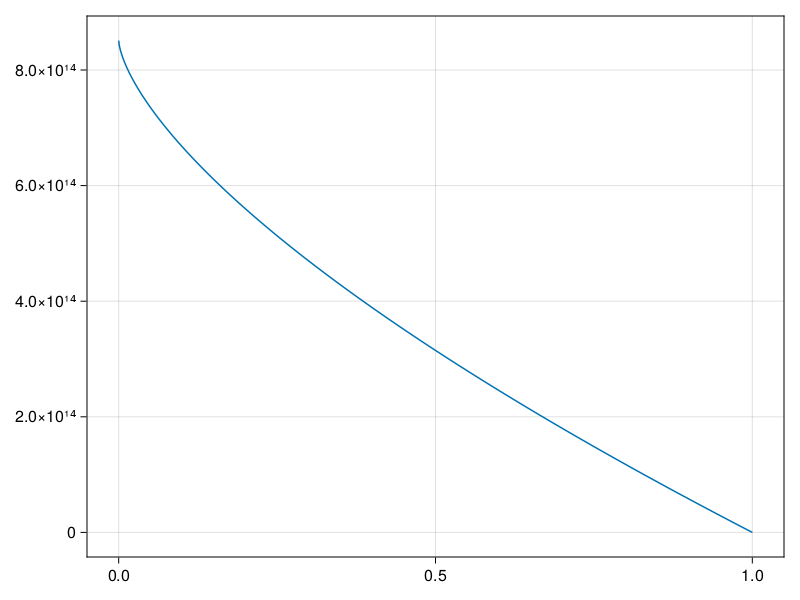

In [4]:
using CairoMakie
f = Figure()
ax = Axis(f[1,1])
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, xvals, T_const_ρ(mass,1,MSUN, 0.7,0.3,StellarChem.get_isotope_list()))
f

In [5]:
isotope_list = StellarChem.get_isotope_list()
for i in 1:sm.nz
    sm.m[i] = MSUN*(i-1)/(sm.nz-1)
    ρ = 1
    XH = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(r_const_ρ(sm.m[i],ρ))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] = log(P_const_ρ(sm.m[i],ρ,MSUN))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]] = log(T_const_ρ(sm.m[i],ρ,MSUN,1.0,0.0,isotope_list))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] = XH
end
#special cases, just copy values at edges
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnr]] = -10
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(2-1)*sm.nvars+sm.vari[:lnP]]
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(2-1)*sm.nvars+sm.vari[:lnT]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnr]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnr]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnP]] = -10
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]] = -10

# add some noise so the solver needs to do some work
sm.ind_vars .= sm.ind_vars .+ rand(sm.nvars*sm.nz)./10;

In [6]:
StellarEvolution.eval_jacobian_row!(sm,1)

4×8 Matrix{Float64}:
  1.0      0.0       0.0  0.0       -1.0   0.0   0.0   0.0
 -1.00206  1.00825  -0.0  0.923351  -0.0  -0.0  -0.0  -0.0
  0.0      0.0       1.0  0.0        0.0   0.0   0.0   0.0
  0.0      0.0       0.0  1.0        0.0   0.0   0.0   0.0

In [10]:
@benchmark StellarEvolution.eval_jacobian_row!(sm,2)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.562 μs … 464.205 μs  ┊ GC (min … max):  0.00% … 94.45%
 Time  (median):     5.362 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   7.406 μs ±  17.926 μs  ┊ GC (mean ± σ):  10.85% ±  4.54%

  ▇█▇▅▄▄▄▄▄▄▃▃▂▂▂▂▁▁                                     ▁    ▂
  ██████████████████▇▇▇▇▇▆▅▅▆▆▅▆▅▄▆▅▅▄▄▄▅▄▆▆▅▄▅▃▅▅▅▃▅▄▅▆███▇▆ █
  4.56 μs      Histogram: log(frequency) by time      23.7 μs <

 Memory estimate: 15.16 KiB, allocs estimate: 75.

In [11]:
@benchmark StellarEvolution.eval_jacobian!(sm)

BenchmarkTools.Trial: 991 samples with 1 evaluation.
 Range (min … max):  1.335 ms … 50.555 ms  ┊ GC (min … max):  0.00% … 93.76%
 Time  (median):     3.289 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   5.033 ms ±  8.732 ms  ┊ GC (mean ± σ):  36.50% ± 18.84%

  ▃▇█▆                                                        
  ████▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆▅▆▇▆▇ ▇
  1.33 ms      Histogram: log(frequency) by time     47.6 ms <

 Memory estimate: 14.87 MiB, allocs estimate: 79889.

In [12]:
for i in 1:4
    StellarEvolution.eval_jacobian!(sm)
    StellarEvolution.eval_eqs!(sm)
    corr = sm.jac\(-sm.eqs)
    #scale correction
    corr = corr*min(1,0.1/maximum(corr))
    @show maximum(corr)
    sm.ind_vars = sm.ind_vars+corr
end

maximum(corr) = 0.09781913232249015
maximum(corr) = 0.05850129670551818
maximum(corr) = 0.00671037029104471


maximum(corr) = 1.7431530765118665e-15


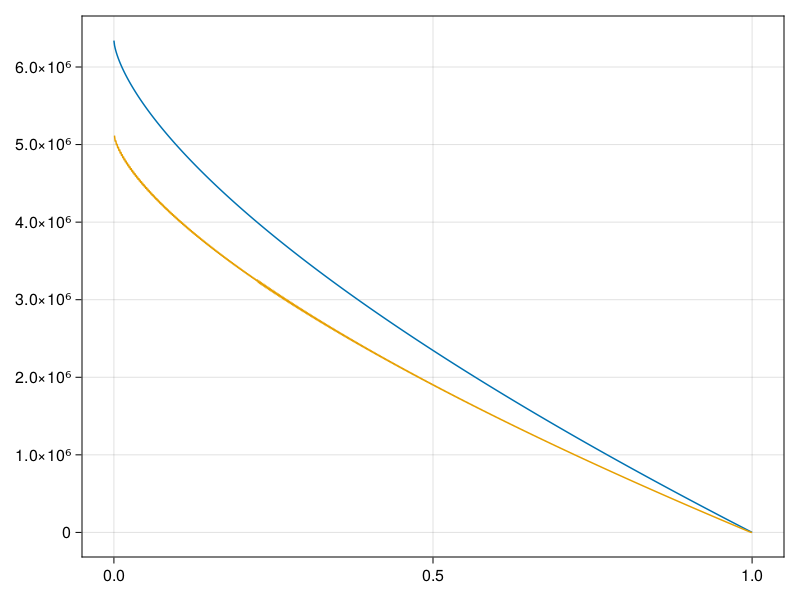

In [13]:
f = Figure()
ax = Axis(f[1,1])
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
lines!(ax, xvals, T_const_ρ(mass,1,MSUN, 0.7,0.3,StellarChem.get_isotope_list()))
lines!(ax, sm.m./sm.mstar, exp.([sm.ind_vars[sm.nvars*(k-1)+sm.vari[:lnT]] for k in 1:sm.nz]))
f